In [5]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict
from statistics import mean
from math import log
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from adjustText import adjust_text
import morfessor
from sklearn.pipeline import Pipeline

dir = '/Users/k/Docs/School/Tuebingen/Thesis/iscl-thesis/2024_corpora/'
files = [os.path.join(dir, file) for file in os.listdir(dir) if file.endswith('.txt')]

languages = {
    'id': 'nat', 
    'tl': 'nat', 
    'tr': 'nat', 
    'en': 'nat', 
    'de': 'nat',
    'fr': 'nat',
    'eo': 'con',
    'lfn': 'con',
    'ia': 'con',
    'io': 'con',
    'pl': 'nat',
    'vi': 'nat',
    'fi': 'nat',
    'it': 'nat',
    'af': 'nat',
    'nl': 'nat',
    'es': 'nat',
    'oc': 'nat',
    'da': 'nat',
    'sv': 'nat',
    'is': 'nat',
    'hu': 'nat',
    'vo': 'con',
    'avk': 'con'
    }

### TTR and MATTR

In [6]:
# TTR
def calculate_ttr(file):
    
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
    f.close()
    
    tokens = text.split()
    total_tokens = len(tokens)
    types = set(tokens)
    total_types = len(types)
    ttr = (total_types / total_tokens) * 100
    return ttr

ttr_values = {}
    
# MATTR
def calculate_mattr(file, window_size):
    
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
    f.close()
    
    tokens = text.split()
    total_tokens = len(tokens)
    
    ttr_values = []
    for i in range(total_tokens - window_size + 1):
        window = tokens[i:i + window_size]
        types = set(window)
        total_types = len(types)
        ttr = total_types / window_size
        ttr_values.append(ttr)

    mattr = sum(ttr_values) / len(ttr_values)
    return mattr

mattr_values = {}
window_size = 100  

### Character and Word Distribution Entropies

In [7]:
# Char Dist Entropy
def log2(number):
    return log(number) / log(2)

def calculate_char_entropy(file):
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
    f.close()
    
    char_freq = {}
    for char in text:
        if char in char_freq:
            char_freq[char] += 1
        else:
            char_freq[char] = 1
            
    length_sum = 0.0
    for char in char_freq:
        p = float(char_freq[char]) / len(text)
        length_sum += p * log2(p)
        
    return -length_sum

char_entropies = {}
    
# Word Dist Entropy
def log2(number):
    return log(number) / log(2)

def calculate_word_entropy(file):
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
    f.close()
    
    word_freq = {}
    total_words = 0
    for word in text.split():
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1
        total_words += 1
            
    length_sum = 0.0
    for word in word_freq:
        p = float(word_freq[word]) / total_words
        length_sum += p * log2(p)
        
    return -length_sum

word_entropies = {}

### Average Word/Sentence Lengths

In [8]:
def calculate_avg_word_len(file):
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
    f.close()
    words = text.split()    
    return (sum(len(word) for word in words)) / len(words)

def calculate_avg_sentence_len(file):
    with open(file, 'r', encoding='utf-8') as f:
        text = f.readlines()
    f.close()
    
    sentence_lengths = []
    for sentence in text:
        words = sentence.split()
        sentence_lengths.append(len(words))
        
    return mean(sentence_lengths)

avg_word_length = {}
avg_sentence_length = {}

for file in files:
    lang = os.path.splitext(os.path.basename(file))[0].split('_')[0]
    ttr_values[lang] = calculate_ttr(file)
    mattr_values[lang] = calculate_mattr(file, window_size)
    char_entropies[lang] = calculate_char_entropy(file)
    word_entropies[lang] = calculate_word_entropy(file)
    avg_word_length[lang] = calculate_avg_word_len(file)
    avg_sentence_length[lang] = calculate_avg_sentence_len(file)

### Morphological Complexity (Morfessor)

In [10]:
# With segmodels2

io = morfessor.MorfessorIO()

def calculate_morph_complexity(file_path):
    model = io.read_binary_model_file(file_path)
    segmentations = [seg[2] for seg in model.get_segmentations()]

    morpheme_tokens = []
    morpheme_types = set()
    segment_counts = []
    stem_forms = defaultdict(list)

    for s in segmentations:
        # Assume the first appearing largest segment is the stem
        stem = max(s, key=len)
        if len(s) > 1:
            morphemes = list(filter(lambda x: (x != stem), s))
            morpheme_tokens.extend(morphemes)
            morpheme_types.update(morphemes)
            
            if stem_forms[stem]:
                stem_forms[stem].extend(morphemes)
            else:
                stem_forms[stem] = morphemes
        else:
            stem_forms[stem].append(None)
            
        segment_counts.append(len(s))

    morpheme_ttr = len(morpheme_types) / len(morpheme_tokens)
    average_segmentations = sum(segment_counts) / len(segment_counts)

    total_forms = 0
    num_stems = len(stem_forms)
    for stem, morphs in stem_forms.items():
        num_morphs = sum(1 for morph in morphs if morph is not None)
        # Total forms including the stem
        total_forms += (num_morphs + 1)
        
    average_forms_per_stem = total_forms / num_stems

    return {
            "Morpheme TTR": morpheme_ttr,
            "Avg Segs Per Word": average_segmentations,
            "Avg Forms Per Stem": average_forms_per_stem
        }

directory_path = "./segmodels2/"
morph_analysis = {}
for filename in os.listdir(directory_path):
    if filename.endswith(".bin"): 
        file_path = os.path.join(directory_path, filename)
        language = os.path.splitext(os.path.basename(filename))[0].split('_')[0]
        morph_analysis[language] = calculate_morph_complexity(file_path)

### Creating Features Dataframe

In [11]:
calculations = {
    'Avg Word Length': avg_word_length,
    'Avg Sentence Length': avg_sentence_length,
    'TTR': ttr_values,
    'MATTR': mattr_values,
    'Char Dist Entr': char_entropies,
    'Word Dist Entr': word_entropies
}
for label, dic in calculations.items():
    calculations[label] = pd.Series(dic)
temp = pd.DataFrame(calculations)
calculations_df = temp.copy()
calculations_df['corpus'] = calculations_df.index
calculations_df = calculations_df[['corpus', 'Avg Word Length', 'Avg Sentence Length', 'TTR', 'MATTR', 'Char Dist Entr', 'Word Dist Entr']]
morph_analysis_df = pd.DataFrame.from_dict(morph_analysis, orient='index').reset_index()
morph_analysis_df.rename(columns={'index': 'corpus'}, inplace=True)
morph_analysis_df.to_csv('./results/morph_analysis_df.csv', index=False)
# Getting the validation loss for the last epoch and last step for each language from the torch_rnn_results.csv file (for text entropy) and using val_perplexity as entropy value 
torch_rnn_df = pd.read_csv('./results/torch_rnn_results.csv', index_col=0)
dfs = []
for lang in languages:
    temp = torch_rnn_df.loc[(torch_rnn_df['epoch'] == 20) & (torch_rnn_df['corpus'] == lang)]
    temp = temp[temp['step'] == temp['step'].max()]
    dfs.append(temp)
ref = pd.concat(dfs)
text_entropy_df = ref[['corpus', 'val_perplexity']]
text_entropy_df.insert(1, 'Type', ref['corpus'].apply(lambda x: languages.get(x)))
text_entropy_df.rename(columns={'val_perplexity':'Text Entr'}, inplace=True)
reverse_lex_entropy_df, lex_entropy_df = pd.read_csv('./results/reverse_lex_entropy_hist_df.csv'), pd.read_csv('./results/lex_entropy_hist_df.csv')
reverse_lex_entropy_df.rename(columns={'val_loss':'Rev Lex Entr'}, inplace=True)
lex_entropy_df.rename(columns={'val_loss':'Lex Entr'}, inplace=True)
# Merge them all together
features_df = pd.merge(morph_analysis_df, calculations_df, on='corpus', how='left')
features_df = pd.merge(features_df, text_entropy_df, on='corpus', how='left')
features_df = pd.merge(features_df, reverse_lex_entropy_df[['corpus', 'Rev Lex Entr']], on='corpus', how='left')
features_df = pd.merge(features_df, lex_entropy_df[['corpus', 'Lex Entr']], on='corpus', how='left')
features_df.rename(columns={'corpus':'Corpus'}, inplace=True)
# Round decimals in table
features_df = features_df.round(decimals=3)
features_df.to_csv('./results/features_df.csv', columns=['Corpus', 'Type', 'Avg Word Length', 'Avg Sentence Length', 'TTR', 'MATTR', 'Morpheme TTR', 'Avg Segs Per Word', 'Avg Forms Per Stem', 'Char Dist Entr', 'Word Dist Entr', 'Text Entr', 'Lex Entr', 'Rev Lex Entr'], index=False)
# features_df.head

/var/folders/1w/_90xn6_52fq9d37y9_7snxr40000gn/T/ipykernel_3008/2115792578.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_entropy_df.rename(columns={'val_perplexity':'Text Entr'}, inplace=True)


### PCA for calculations_df

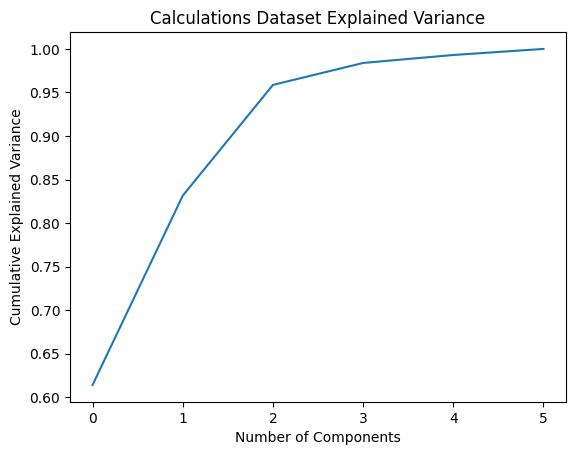

In [14]:
# DETERMINING NUMBER OF PRINCIPLE COMPONENTS TO USE FOR CALCULATIONS DATA (from https://medium.com/analytics-vidhya/feature-extraction-techniques-pca-lda-and-t-sne-df0459c723aa)

numeric_df = calculations_df.select_dtypes(include='number')

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

pca = PCA()
pca.fit_transform(scaled_data)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')  # for each component
plt.title('Calculations Dataset Explained Variance')
plt.savefig('./results/Calculations Data')
plt.show(block=True)

/var/folders/1w/_90xn6_52fq9d37y9_7snxr40000gn/T/ipykernel_8482/1218876109.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts.append(plt.annotate(language, (pca_df['PC1'][i], pca_df['PC2'][i])))


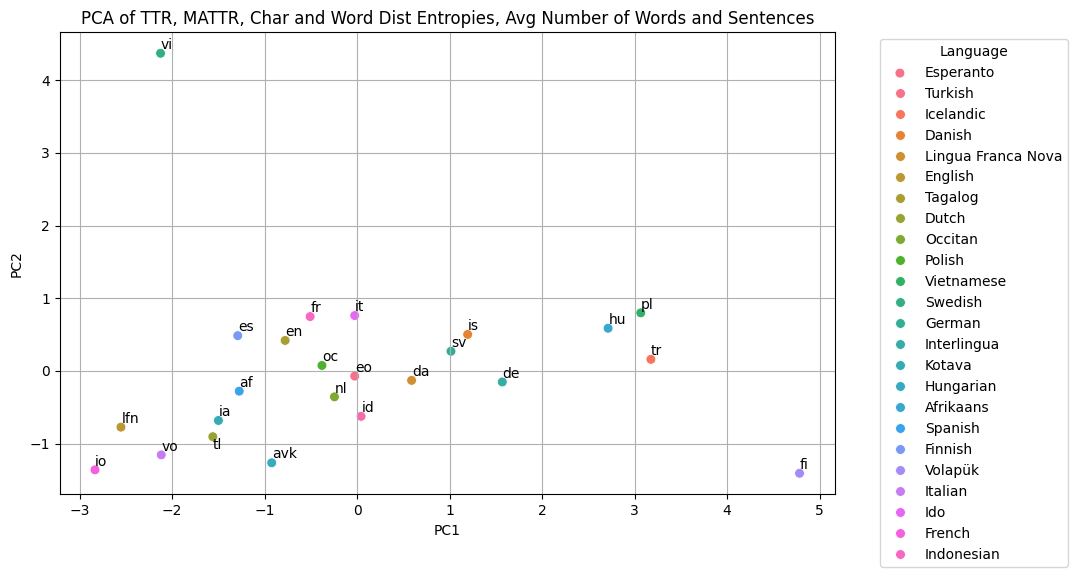

In [15]:
numeric_df = calculations_df.select_dtypes(include='number')

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df.index = calculations_df.index

# print(pca_df)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, hue=pca_df.index, s=50)

texts = []
for i, language in enumerate(pca_df.index):
    texts.append(plt.annotate(language, (pca_df['PC1'][i], pca_df['PC2'][i])))
    
adjust_text(texts)

lang_labels = {
    'sv': 'Swedish', 
    'id': 'Indonesian', 
    'eo': 'Esperanto',
    'is': 'Icelandic',
    'pl': 'Polish',
    'da': 'Danish',
    'tl': 'Tagalog',
    'ia': 'Interlingua',
    'fi': 'Finnish',
    'vi': 'Vietnamese',
    'hu': 'Hungarian',
    'nl': 'Dutch',
    'lfn': 'Lingua Franca Nova',
    'es': 'Spanish',
    'io': 'Ido',
    'af': 'Afrikaans',
    'fr': 'French',
    'it': 'Italian',
    'tr': 'Turkish',
    'de': 'German',
    'oc': 'Occitan',
    'en': 'English',
    'vo': 'Volapük',
    'avk': 'Kotava'
    }
legend_labels = [lang_labels[abb] for abb in pca_df.index]
    
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of TTR, MATTR, Char and Word Dist Entropies, Avg Number of Words and Sentences')
plt.grid(True)
plt.legend(title='Language', labels=legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
plt.savefig('./results/PCA_of_TTR_MATTR_Char_and_word_distr_Avg number of words and sentences')
plt.show()

### PCA of All Features

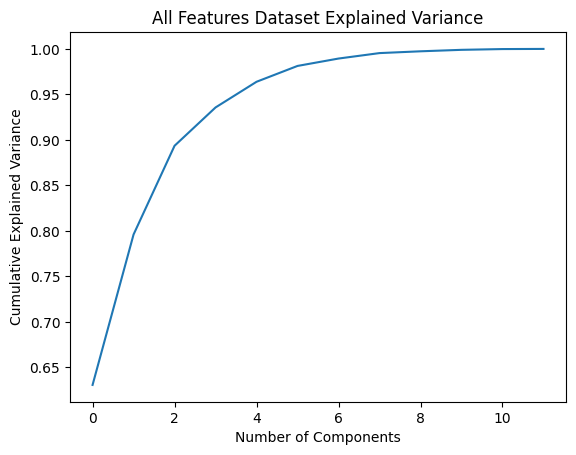

In [12]:
# DETERMINING NUMBER OF PRINCIPLE COMPONENTS TO USE FOR ALL FEATURES DATA (from https://medium.com/analytics-vidhya/feature-extraction-techniques-pca-lda-and-t-sne-df0459c723aa)

numeric_df2 = features_df.select_dtypes(include='number')

scaler2 = StandardScaler()
scaled_data2 = scaler2.fit_transform(numeric_df2)
pca2 = PCA()
pca2.fit_transform(scaled_data2)

plt.figure()
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')  # for each component
plt.title('All Features Dataset Explained Variance')
plt.savefig('./results/All_features_dataset_explained_variance.png')
plt.show(block=True)

### Determining number of principal components with elbow criterion (from https://statisticsglobe.com/scree-plot-pca-python)

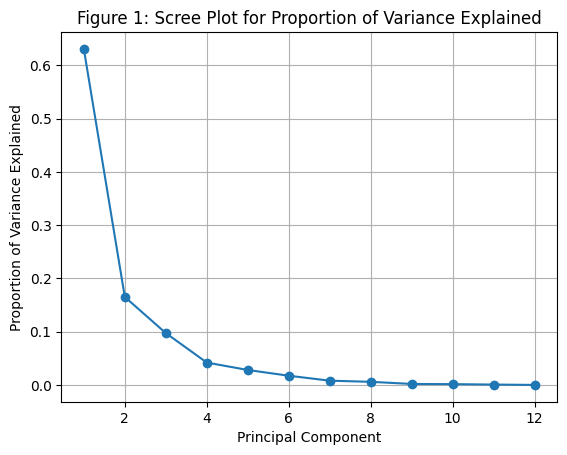

In [13]:
# DETERMINING NUMBER OF PRINCIPLE COMPONENTS TO USE FOR ALL FEATURES DATA (from https://statisticsglobe.com/scree-plot-pca-python)
# Without considering Kaiser's rule

numeric_df2 = features_df.select_dtypes(include='number')

scaler2 = StandardScaler()
scaled_data2 = scaler2.fit_transform(numeric_df2)
pca2 = PCA()
pca2.fit_transform(scaled_data2)

eigenvalues = pca2.explained_variance_
prop_var = eigenvalues / np.sum(eigenvalues)

plt.figure()
plt.plot(np.arange(1, len(prop_var)+1), 
                   prop_var, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Figure 1: Scree Plot for Proportion of Variance Explained')
plt.grid(True)
plt.savefig('./results/ScreePlot_for_Proportion of Variance Explained')

### Determining number of principal components with Kaiser criterion (from https://statisticsglobe.com/scree-plot-pca-python)

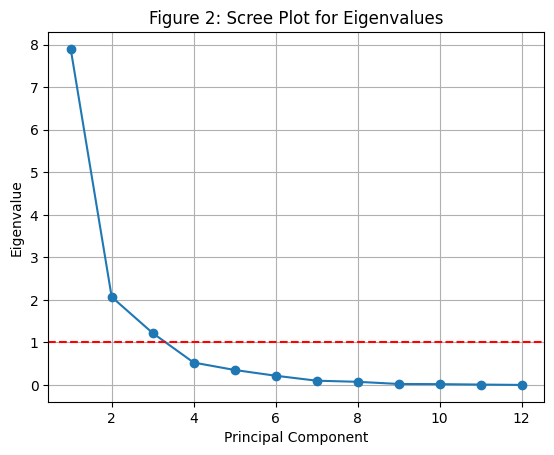

In [14]:
numeric_df2 = features_df.select_dtypes(include='number')

scaler2 = StandardScaler()
scaled_data2 = scaler2.fit_transform(numeric_df2)
pca2 = PCA()
pca2.fit_transform(scaled_data2)

eigenvalues = pca2.explained_variance_
prop_var = eigenvalues / np.sum(eigenvalues)

plt.figure()
plt.plot(np.arange(1, len(eigenvalues)+1), 
         eigenvalues, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Figure 2: Scree Plot for Eigenvalues',)
plt.axhline(y=1, color='r', 
            linestyle='--')
plt.grid(True)
plt.savefig('./results/PCA_ScreePlot_for_Eigenvalues')

/var/folders/1w/_90xn6_52fq9d37y9_7snxr40000gn/T/ipykernel_3008/1264275502.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts.append(plt.annotate(language, (pca_df3['PC1'][i], pca_df3['PC2'][i])))


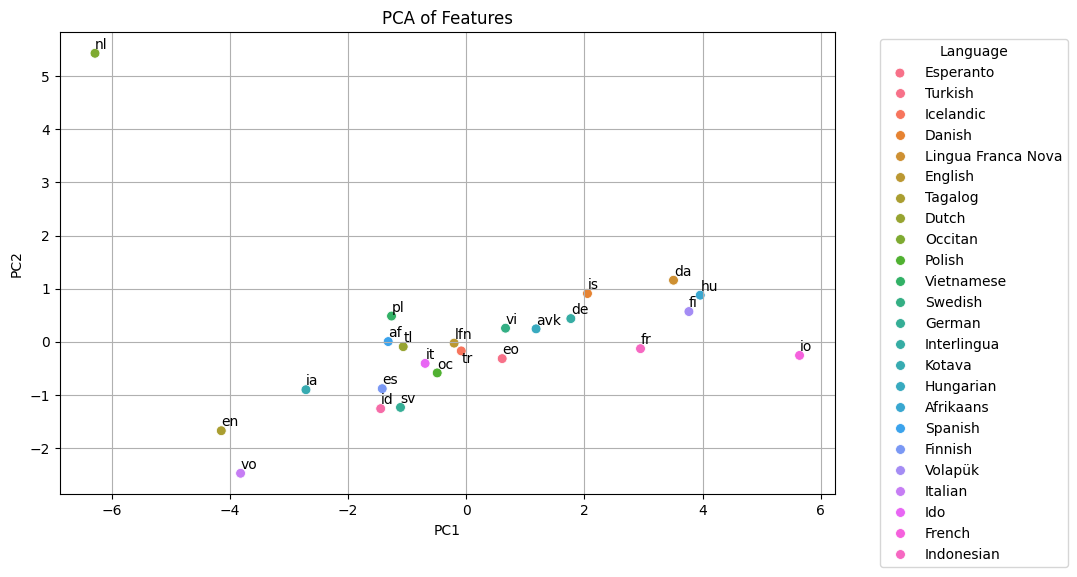

In [15]:
numeric_df3 = features_df.select_dtypes(include='number')
scaler3 = StandardScaler()
scaled_data3 = scaler.fit_transform(numeric_df3)
pca3 = PCA(n_components=2)
pca_result3 = pca3.fit_transform(scaled_data3)
pca_df3 = pd.DataFrame(pca_result3, columns=['PC1', 'PC2'])
pca_df3.index = calculations_df.index

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df3, hue=pca_df3.index, s=50)

texts = []
for i, language in enumerate(pca_df3.index):
    texts.append(plt.annotate(language, (pca_df3['PC1'][i], pca_df3['PC2'][i])))
    
adjust_text(texts)

lang_labels = {
    'sv': 'Swedish', 
    'id': 'Indonesian', 
    'eo': 'Esperanto',
    'is': 'Icelandic',
    'pl': 'Polish',
    'da': 'Danish',
    'tl': 'Tagalog',
    'ia': 'Interlingua',
    'fi': 'Finnish',
    'vi': 'Vietnamese',
    'hu': 'Hungarian',
    'nl': 'Dutch',
    'lfn': 'Lingua Franca Nova',
    'es': 'Spanish',
    'io': 'Ido',
    'af': 'Afrikaans',
    'fr': 'French',
    'it': 'Italian',
    'tr': 'Turkish',
    'de': 'German',
    'oc': 'Occitan',
    'en': 'English',
    'vo': 'Volapük',
    'avk': 'Kotava'
    }
legend_labels3 = [lang_labels[abb] for abb in pca_df3.index]
    
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Features')
plt.grid(True)
plt.legend(title='Language', labels=legend_labels3, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('./results/PCA of All Features.png')
# plt.tight_layout()
plt.show()

In [17]:
components_df = pd.DataFrame(pca3.components_, columns=numeric_df3.columns, index=['PC1', 'PC2'])
# print(components_df)
# print(pca3.explained_variance_ratio_)

def get_top_features(components_df, pc_name, top_n=1):
    pc_loadings = components_df.loc[pc_name]
    top_features = pc_loadings.abs().nlargest(top_n).index
    return top_features.tolist()

print(get_top_features(components_df, 'PC1')[0], get_top_features(components_df, 'PC2')[0])

TTR Char Dist Entr


In [13]:
# # 3D VISUALIZATION, 3 PRINCIPLE COMPONENTS

# fig = plt.figure(figsize=(14,9))
# ax = fig.add_subplot(111, 
#                      projection='3d')
 
# for l in np.unique(y):
#  ix=np.where(y==l)
#  ax.scatter(Xax[ix], 
#             Yax[ix], 
#             Zax[ix], 
#             c=cdict[l], 
#             s=60,
#            label=label[l])
 
# ax.set_xlabel("PC1", 
#               fontsize=12)
# ax.set_ylabel("PC2", 
#               fontsize=12)
# ax.set_zlabel("PC3", 
#               fontsize=12)
 
# ax.view_init(30, 125)
# ax.legend()
# plt.title("PCA: Three Components")
# plt.show()

# numeric_df3 = features_df.select_dtypes(include='number')

# scaler3 = StandardScaler()
# scaled_data3 = scaler.fit_transform(numeric_df3)

# pca3 = PCA(n_components=2)
# pca_result3 = pca3.fit_transform(scaled_data3)

# pca_df3 = pd.DataFrame(pca_result3, columns=['PC1', 'PC2'])
# pca_df3.index = calculations_df.index

# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='PC1', y='PC2', data=pca_df3, hue=pca_df3.index, s=50)

# texts = []
# for i, language in enumerate(pca_df3.index):
#     texts.append(plt.annotate(language, (pca_df3['PC1'][i], pca_df3['PC2'][i])))
    
# adjust_text(texts)

# lang_labels = {
#     'sv': 'Swedish', 
#     'id': 'Indonesian', 
#     'eo': 'Esperanto',
#     'is': 'Icelandic',
#     'pl': 'Polish',
#     'da': 'Danish',
#     'tl': 'Tagalog',
#     'ia': 'Interlingua',
#     'fi': 'Finnish',
#     'vi': 'Vietnamese',
#     'hu': 'Hungarian',
#     'nl': 'Dutch',
#     'lfn': 'Lingua Franca Nova',
#     'es': 'Spanish',
#     'io': 'Ido',
#     'af': 'Afrikaans',
#     'fr': 'French',
#     'it': 'Italian',
#     'tr': 'Turkish',
#     'de': 'German',
#     'oc': 'Occitan',
#     'en': 'English',
#     'vo': 'Volapük',
#     'avk': 'Kotava'
#     }
# legend_labels3 = [lang_labels[abb] for abb in pca_df3.index]
    
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.title('PCA of Features')
# plt.grid(True)
# plt.legend(title='Language', labels=legend_labels3, bbox_to_anchor=(1.05, 1), loc='upper left')
# # plt.tight_layout()
# plt.show()

Variance Ratio

In [14]:
# Follow https://medium.com/analytics-vidhya/feature-extraction-techniques-pca-lda-and-t-sne-df0459c723aa for plotting cumulative explained variance ratio

In [13]:
pca.explained_variance_ratio_

array([0.61409205, 0.21738354])